In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [8]:
image_size = (256, 256)
batch_size = 32

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "leaf",
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 104 files belonging to 2 classes.
Using 84 files for training.
Using 20 files for validation.


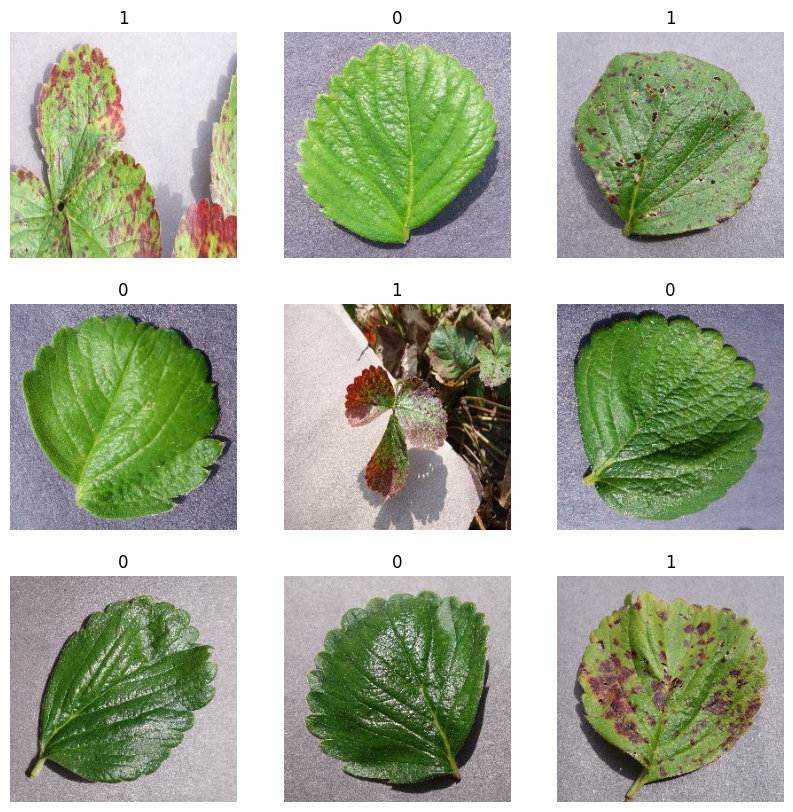

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2, fill_mode='nearest'),
    layers.RandomZoom(0.3),
]
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

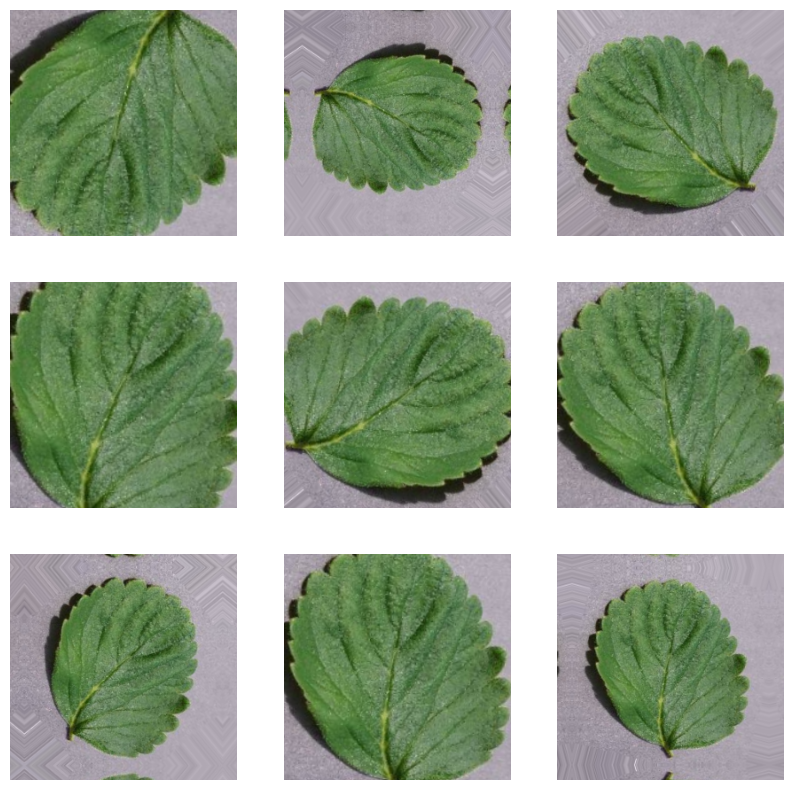

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [ ]:
from tensorflow import data as tf_data
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

In [28]:
model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=image_size + (3,),classes=2,
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

model.add(pretrained_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # number of neuron=number of classes and activation = softmax

In [29]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])  #use categorical_crossentropy for multiclass

In [30]:
#https://stackoverflow.com/questions/61742556/valueerror-shapes-none-1-and-none-2-are-incompatible
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.6421 - loss: 15.1099 - val_accuracy: 0.8500 - val_loss: 3.7206
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.8841 - loss: 3.7812 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.9470 - loss: 1.5288 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 1.0000 - loss: 9.7589e-14 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 1.0000 - loss: 2.9677e-16 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


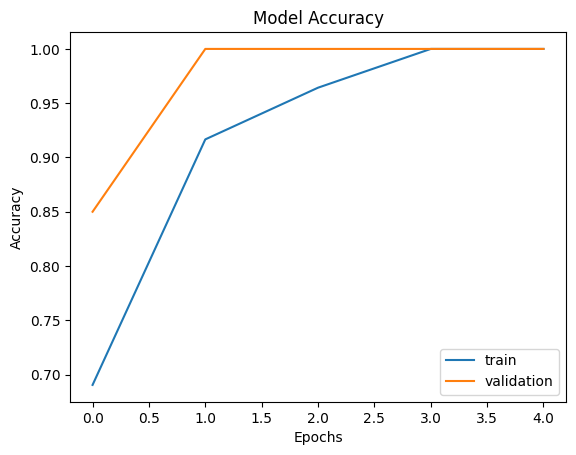

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.axis(ymin=0.4,ymax=1)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

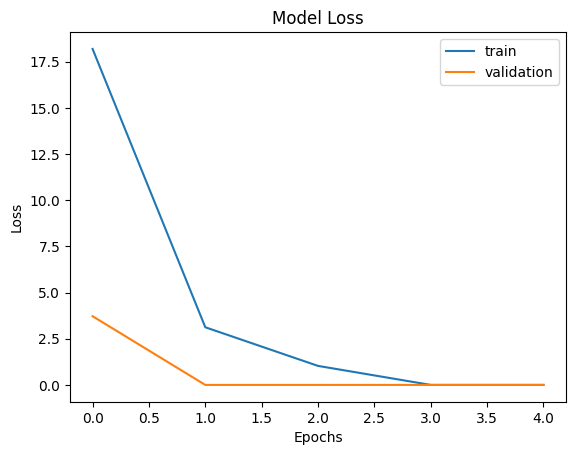

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [33]:
pred = model.predict(val_ds)
#prediction = np.argmax(pred, axis=1) #for multiclass, remove comment
#print(val_ds.classes)

val_label = np.concatenate([y for x, y in val_ds], axis=0)
prediction = np.where(pred >= 0.5, 1, 0).flatten()  #for multiclass make a comment
print(pred)
print(prediction)
print(val_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]]
[1 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1]
[1 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1]


<Axes: >

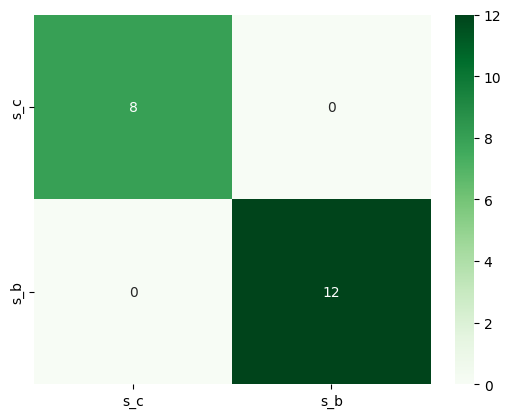

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

categories = ['s_c', 's_b']

cm = confusion_matrix(val_label, prediction)
sns.heatmap(cm, cmap="Greens", annot=True, xticklabels = categories, yticklabels = categories)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

print(accuracy_score(val_label, prediction))
print(classification_report(val_label, prediction, target_names=categories))

1.0
              precision    recall  f1-score   support

         s_c       1.00      1.00      1.00         8
         s_b       1.00      1.00      1.00        12

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [ ]:
import cv2
image=cv2.imread("test2.JPG")
image_resized= cv2.resize(image, (256, 256))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)

pred=model.predict(image)
print(pred)

#output_class=val_ds.class_names[np.argmax(pred)]   # remove comment for multiclass, and make comments for below code
#print("The predicted class is", output_class)

s_f = 100 * (1 - pred)
s_b = 100 * pred

if(s_f > s_b):
  print("This image is s_f")
else:
  print("This image is s_d")

(1, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[[1.]]
This image is s_d
